Import all the required libraries to execute the project

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn import metrics

from sklearn.manifold import TSNE
from sklearn.decomposition import  PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

Read the human activity recognition dataset and form a dataframe

In [2]:
url = 'https://drive.google.com/uc?id=1aVbtQiGnLSJdbofzdKyLenbjF0QoHcKE'
train_data = pd.read_csv(url)
url = 'https://drive.google.com/uc?id=1z6r9Rlv_hhnKu7eqxktVd2H7svQXauP_'
test_data = pd.read_csv(url)

print(train_data.head())
print(train_data.shape)
print(train_data.describe())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

 Exploring angle between x and gravity

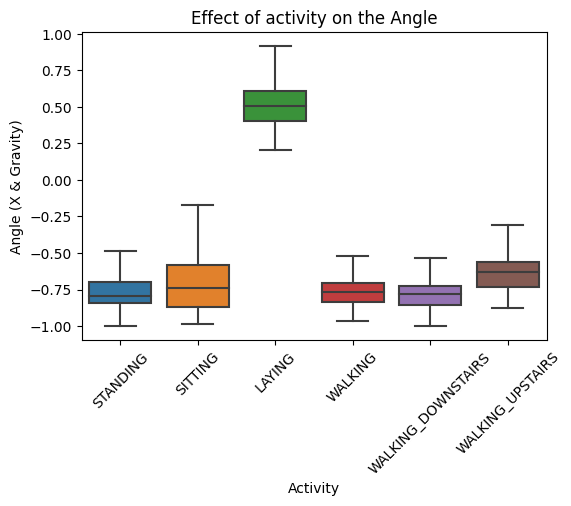

In [3]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train_data, showfliers=False)
plt.title('Effect of activity on the Angle')
plt.xlabel("Activity")
plt.ylabel('Angle (X & Gravity)')
plt.xticks(rotation = 45)
plt.show()

If angle(X,gravityMean) > 0 then Activity is Laying.

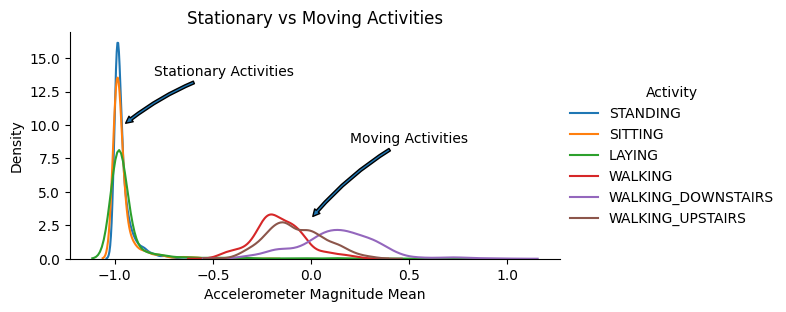

In [4]:
facetgrid = sns.FacetGrid(train_data, hue='Activity', aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMag-mean()', hist=False).add_legend()
plt.annotate("Stationary Activities",xy=(-0.956,10),xytext=(-0.8, 14),va='center',ha='left',\
             arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.annotate("Moving Activities",xy=(0,3),xytext=(0.2, 9),va='center',ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.title("Stationary vs Moving Activities")
plt.xlabel("Accelerometer Magnitude Mean")
plt.ylabel("Density")
plt.show()

classifying activities into static and dynamic

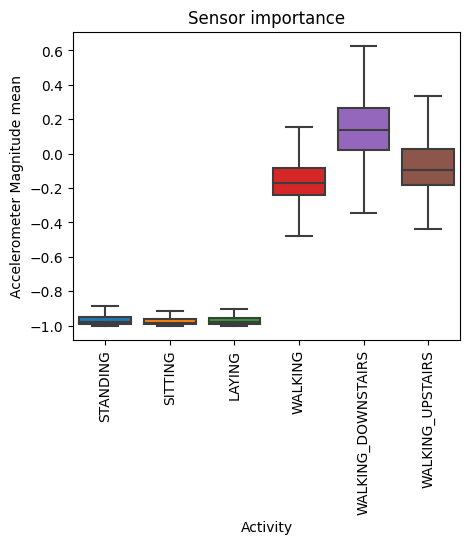

In [5]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()',data=train_data, showfliers=False, saturation=1)
plt.title("Sensor importance")
plt.xlabel("Activity")
plt.ylabel('Accelerometer Magnitude mean')
plt.xticks(rotation="vertical")
plt.show()

Lets check for the imbalance in data. Having balanced data is important for improving accuracy of the model

In [6]:
fig = px.pie(train_data, names='Activity')
fig.update_layout(title="Activities distribution in the data", legend_title ="Activities")
fig.update_layout(width=500, height=500)
fig.show()

Remove missing data

In [7]:
columns = train_data.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train_data.columns = columns
test_data.columns = columns

Principal Component Analysis (PCA)

In [8]:
data = pd.concat([train_data, test_data])

#Frequency domain
f_df = data.loc[:, data.columns.str.contains('^f|^s|^a|^A')]

#Time domain
t_df = data.loc[:, data.columns.str.contains('^t|^s|^a|^A')]

X = data.drop(['subject', 'Activity'], axis=1)
y = data['Activity']

X_f = f_df.drop(['subject', 'Activity'], axis=1)
y_f = f_df['Activity']

X_t = t_df.drop(['subject', 'Activity'], axis=1)
y_t = t_df['Activity']

pca = PCA(n_components=0.99)
pca.fit(X)
x_reduced = pca.transform(X)

print('Frequency components number is {}, Time components number is {}'.format(X_f.shape[1], X.shape[1] - X_f.shape[1]))
print('Original number of features {}, Reduced number of features {}'.format(X.shape[1], x_reduced.shape[1]))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_reduced, y, test_size=0.2, shuffle=True, random_state=42)
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, shuffle=True, random_state=42)
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, shuffle=True, random_state=42)

Frequency components number is 296, Time components number is 265
Original number of features 561, Reduced number of features 157


Modeling

In [9]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}, Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}, Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}, Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    predicted = model.predict(X_test)
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted, display_labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING',\
                                                                                         'DOWNSTAIRS','UPSTAIRS'], xticks_rotation="vertical")

Logistic Regression

Training Accuracy Logistic Regression 98.90763442165311, Test Accuracy Logistic Regression 98.15533980582525
Training Precesion Logistic Regression 98.90763442165311, Test Precesion Logistic Regression 98.15533980582525
Training Recall Logistic Regression 98.90763442165311, Test Recall Logistic Regression 98.15533980582525


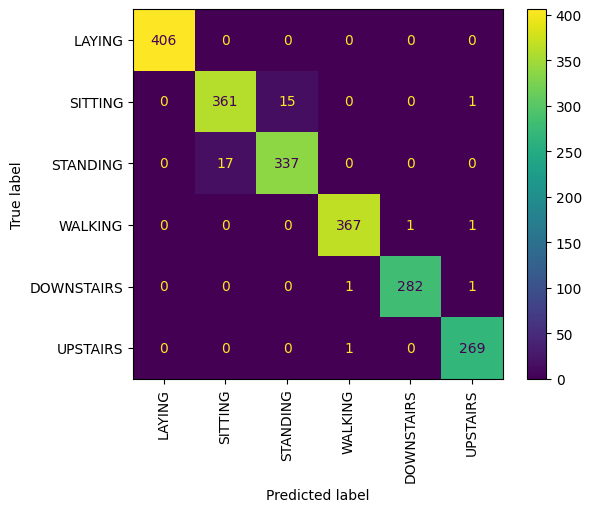

In [10]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)

Linear Discriminant Analysis (LDA)

Training Accuracy LinearDiscriminantAnalysis 98.37358902779464, Test Accuracy LinearDiscriminantAnalysis 97.57281553398059
Training Precesion LinearDiscriminantAnalysis 98.37358902779464, Test Precesion LinearDiscriminantAnalysis 97.57281553398059
Training Recall LinearDiscriminantAnalysis 98.37358902779464, Test Recall LinearDiscriminantAnalysis 97.57281553398059


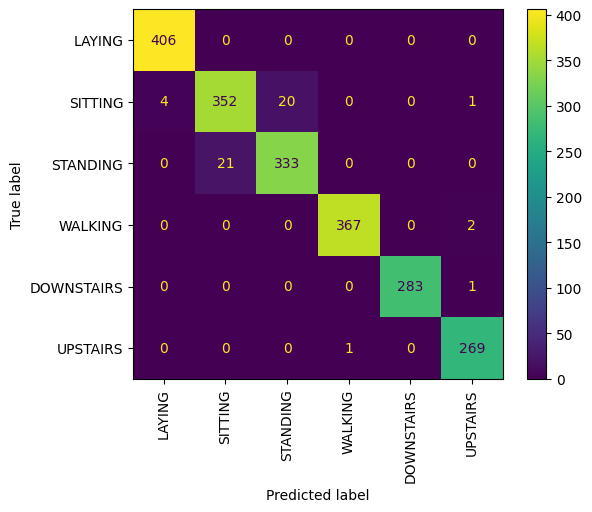

In [11]:
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
evaluate_classification(lda, "LinearDiscriminantAnalysis", x_train, x_test, y_train, y_test)

k-nearest neighbors

Training Accuracy KNeighborsClassifier 95.35137759436824, Test Accuracy KNeighborsClassifier 94.51456310679612
Training Precesion KNeighborsClassifier 95.35137759436824, Test Precesion KNeighborsClassifier 94.51456310679612
Training Recall KNeighborsClassifier 95.35137759436824, Test Recall KNeighborsClassifier 94.51456310679612


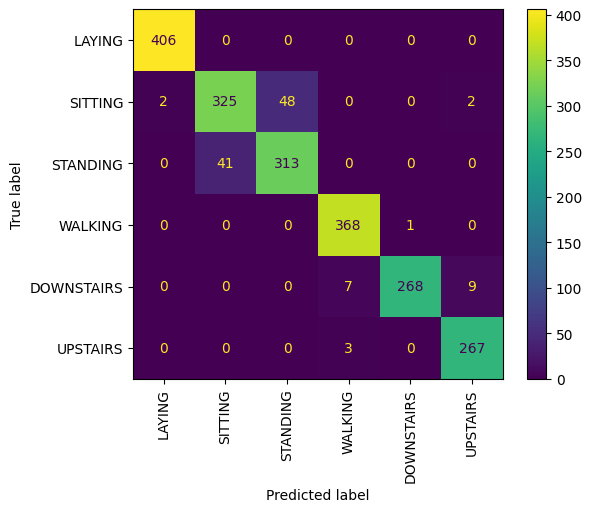

In [12]:
knn = KNeighborsClassifier(n_neighbors=30).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

Naive Bayes

Training Accuracy GaussianNB 73.06711979609176, Test Accuracy GaussianNB 74.6116504854369
Training Precesion GaussianNB 73.06711979609176, Test Precesion GaussianNB 74.6116504854369
Training Recall GaussianNB 73.06711979609176, Test Recall GaussianNB 74.6116504854369


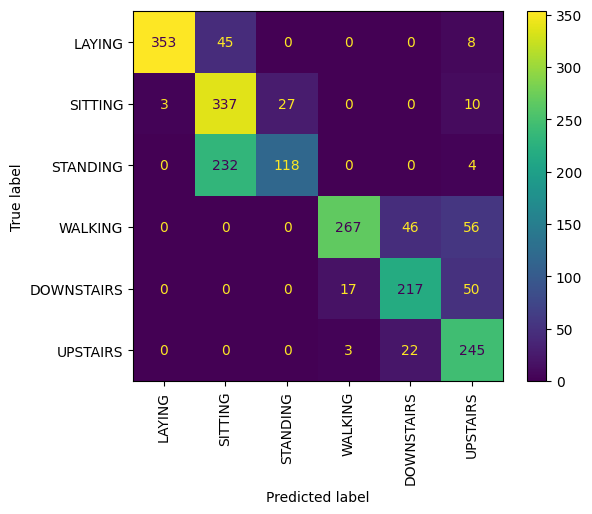

In [13]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

Support Vector Machines

Training Accuracy Linear SVC(LBasedImpl) 99.38099283893676, Test Accuracy Linear SVC(LBasedImpl) 98.64077669902913
Training Precesion Linear SVC(LBasedImpl) 99.38099283893676, Test Precesion Linear SVC(LBasedImpl) 98.64077669902913
Training Recall Linear SVC(LBasedImpl) 99.38099283893676, Test Recall Linear SVC(LBasedImpl) 98.64077669902913


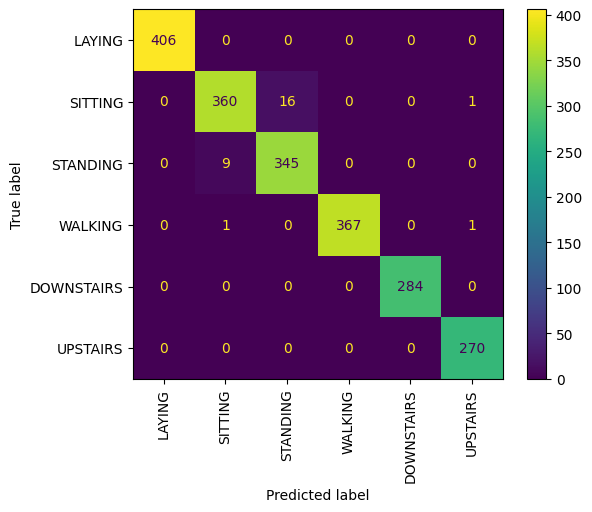

In [14]:
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

Training Accuracy RBF SVC 97.7909940526763, Test Accuracy RBF SVC 97.23300970873787
Training Precesion RBF SVC 97.7909940526763, Test Precesion RBF SVC 97.23300970873787
Training Recall RBF SVC 97.7909940526763, Test Recall RBF SVC 97.23300970873787


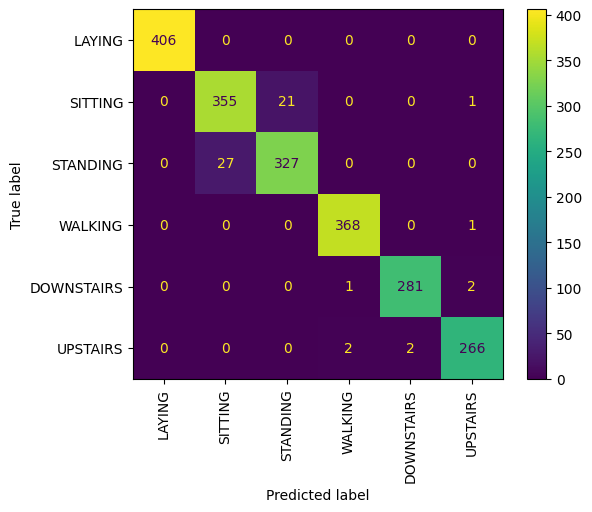

In [15]:
rbf = svm.SVC(kernel='rbf').fit(x_train, y_train)
evaluate_classification(rbf, "RBF SVC", x_train, x_test, y_train, y_test)

Decision Tree

Training Accuracy DecisionTreeClassifier 100.0, Test Accuracy DecisionTreeClassifier 92.5242718446602
Training Precesion DecisionTreeClassifier 100.0, Test Precesion DecisionTreeClassifier 92.5242718446602
Training Recall DecisionTreeClassifier 100.0, Test Recall DecisionTreeClassifier 92.5242718446602


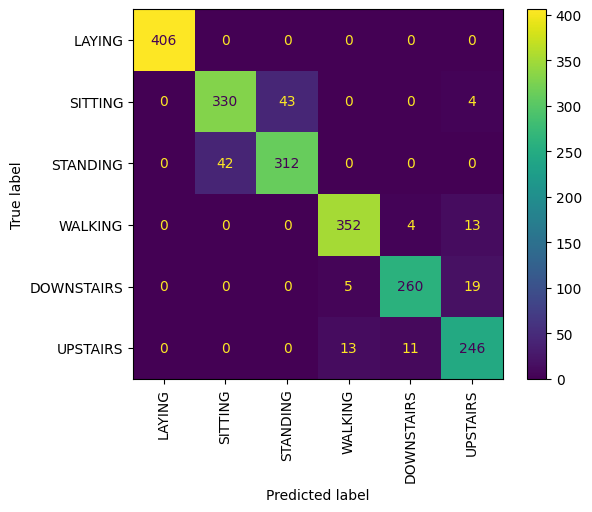

In [16]:
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

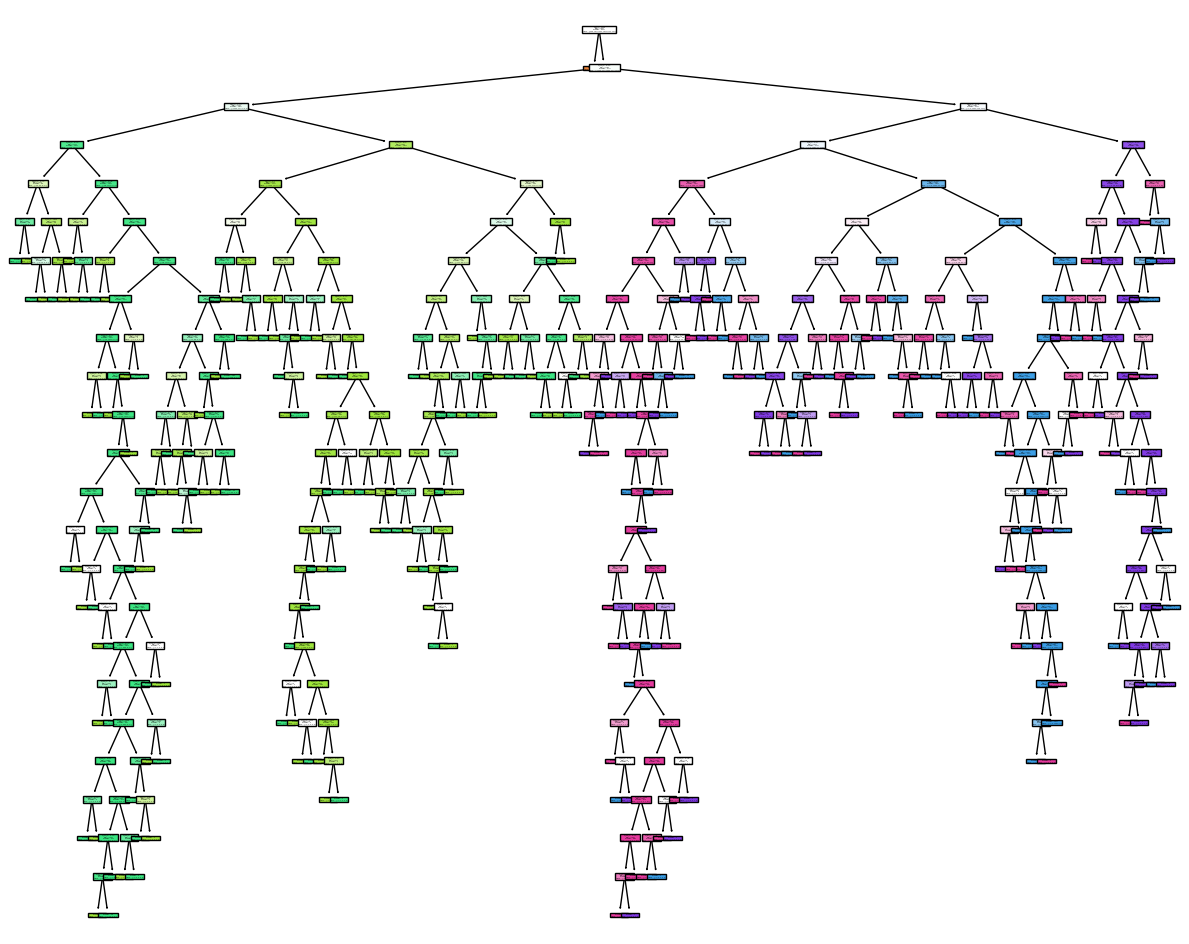

In [17]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(tdt , filled=True)
plt.show()

RandomForest Classifier

Training Accuracy RandomForestClassifier 100.0, Test Accuracy RandomForestClassifier 97.81553398058253
Training Precesion RandomForestClassifier 100.0, Test Precesion RandomForestClassifier 97.81553398058253
Training Recall RandomForestClassifier 100.0, Test Recall RandomForestClassifier 97.81553398058253


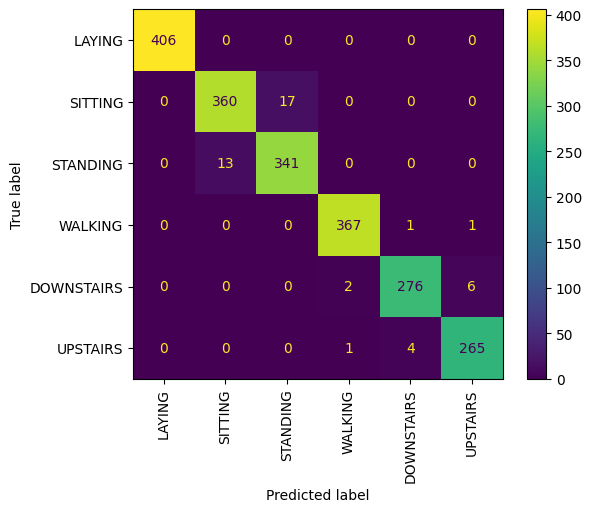

In [18]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

XGBOOST Classifier

Training Accuracy XGBClassifier 98.83481004976332, Test Accuracy XGBClassifier 97.37864077669903
Training Precesion XGBClassifier 98.83481004976332, Test Precesion XGBClassifier 97.37864077669903
Training Recall XGBClassifier 98.83481004976332, Test Recall XGBClassifier 97.37864077669903


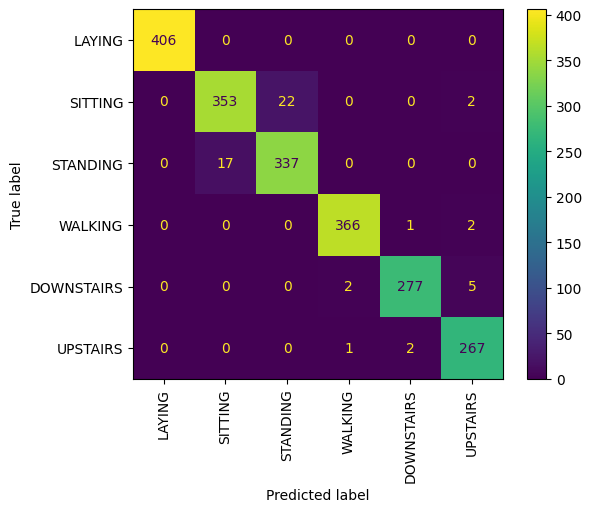

In [19]:
le = preprocessing.LabelEncoder().fit(y_train)
y_xgb_train = le.transform(y_train)
y_xgb_test = le.transform(y_test)

xgb_params = {'n_estimators': 100,
              'learning_rate': 0.2,
              'subsample': 0.927,
              'colsample_bytree': 0.88,
              'max_depth': 5,
              'booster': 'gbtree', 
              'reg_lambda': 38,
              'reg_alpha': 32,
              'random_state': 12}
xgb = XGBClassifier(**xgb_params).fit(x_train, y_xgb_train)
evaluate_classification(xgb, "XGBClassifier", x_train, x_test, y_xgb_train, y_xgb_test)

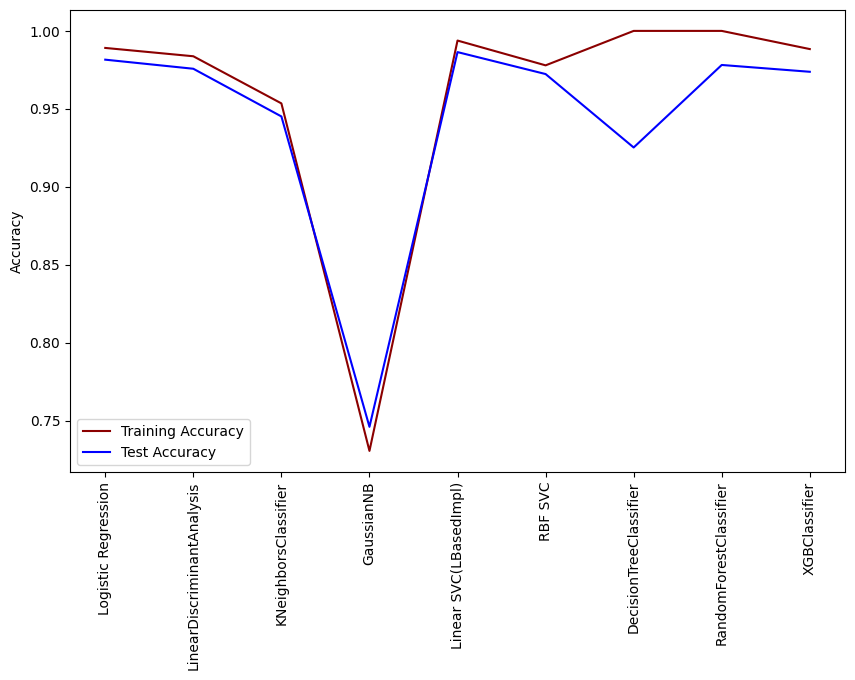

In [20]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(len(keys)) , [value[0] for value in values], color='darkred')
ax.plot(np.arange(len(keys)) , [value[1] for value in values], color='b')
ax.legend(["Training Accuracy", "Test Accuracy"])
ax.set_xticklabels(keys, rotation='vertical')
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Accuracy")
plt.show()

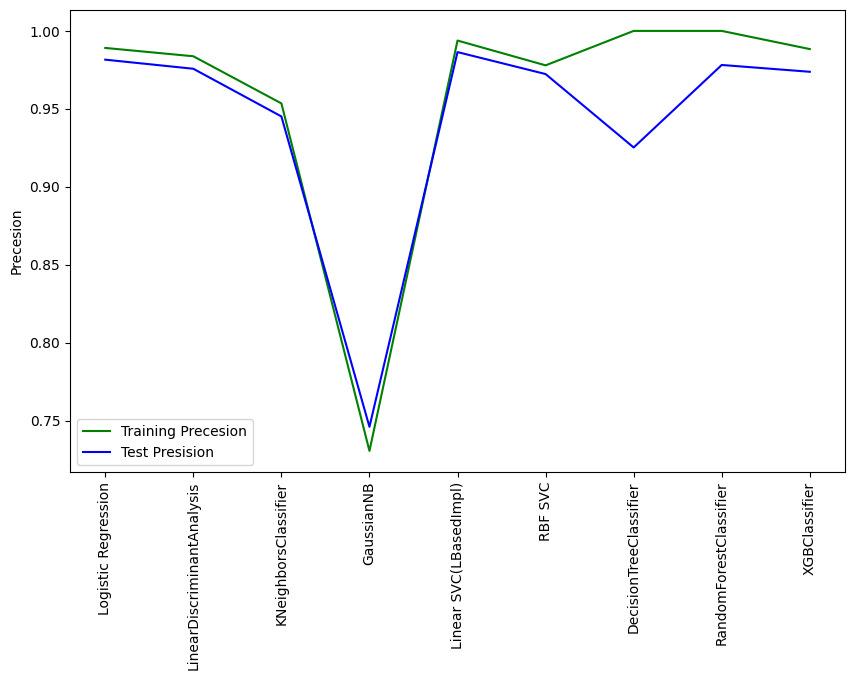

In [21]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(len(keys)), [value[2] for value in values], color='g')
ax.plot(np.arange(len(keys)), [value[3] for value in values], color='b')
ax.legend(["Training Precesion", "Test Presision"])
ax.set_xticklabels(keys, rotation='vertical')
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Precesion")
plt.show()

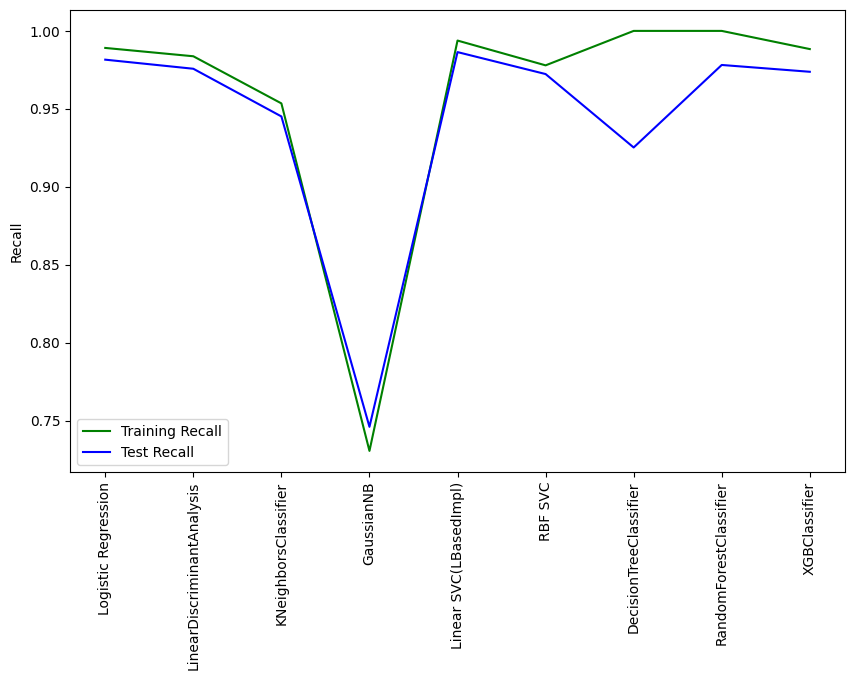

In [22]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(len(keys)), [value[4] for value in values], color='g')
ax.plot(np.arange(len(keys)), [value[5] for value in values], color='b')
ax.legend(["Training Recall", "Test Recall"])
ax.set_xticklabels(keys, rotation='vertical')
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Recall")
plt.show()

Feature reduction with PCA vs. manual way

Training Accuracy Linear SVC(PCA) 99.04114577011774, Test Accuracy Linear SVC(PCA) 98.15533980582525
Training Precesion Linear SVC(PCA) 99.04114577011774, Test Precesion Linear SVC(PCA) 98.15533980582525
Training Recall Linear SVC(PCA) 99.04114577011774, Test Recall Linear SVC(PCA) 98.15533980582525


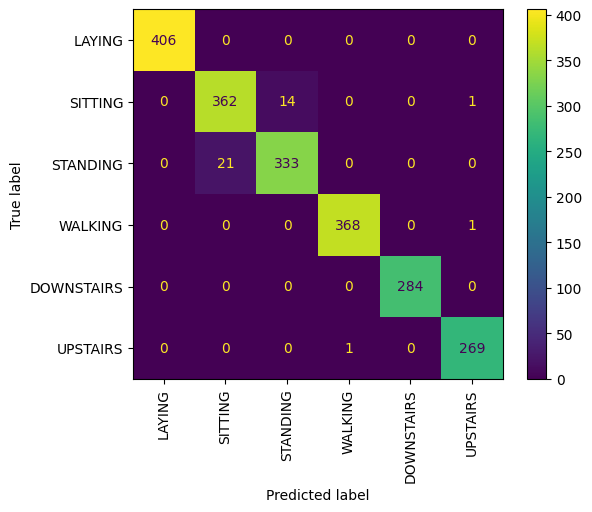

In [23]:
lin_svc_pca = svm.LinearSVC().fit(x_train_pca, y_train_pca)
evaluate_classification(lin_svc_pca, "Linear SVC(PCA)", x_train_pca, x_test_pca, y_train_pca, y_test_pca)

Time vs. Frequency

Training Accuracy Linear SVC(Frequency) 97.70603228547154, Test Accuracy Linear SVC(Frequency) 96.11650485436894
Training Precesion Linear SVC(Frequency) 97.70603228547154, Test Precesion Linear SVC(Frequency) 96.11650485436894
Training Recall Linear SVC(Frequency) 97.70603228547154, Test Recall Linear SVC(Frequency) 96.11650485436894


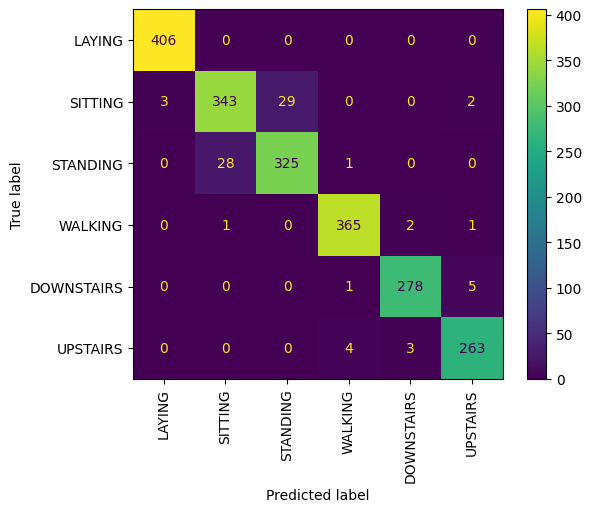

In [24]:
lin_svc_f = svm.LinearSVC().fit(x_train_f, y_train_f)
evaluate_classification(lin_svc_f, "Linear SVC(Frequency)", x_train_f, x_test_f, y_train_f, y_test_f)

Training Accuracy Linear SVC(Time) 99.17465711858236, Test Accuracy Linear SVC(Time) 98.54368932038835
Training Precesion Linear SVC(Time) 99.17465711858236, Test Precesion Linear SVC(Time) 98.54368932038835
Training Recall Linear SVC(Time) 99.17465711858236, Test Recall Linear SVC(Time) 98.54368932038835


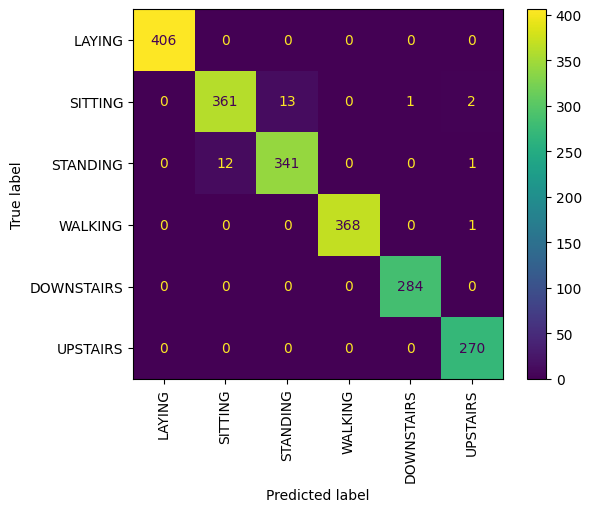

In [25]:
lin_svc_t = svm.LinearSVC().fit(x_train_t, y_train_t)
evaluate_classification(lin_svc_t, "Linear SVC(Time)", x_train_t, x_test_t, y_train_t, y_test_t)

Number of best for Anova is 180
Training Accuracy Linear SVC(K) 98.60419953877899, Test Accuracy Linear SVC(K) 97.71844660194175
Training Precesion Linear SVC(K) 98.60419953877899, Test Precesion Linear SVC(K) 97.71844660194175
Training Recall Linear SVC(K) 98.60419953877899, Test Recall Linear SVC(K) 97.71844660194175


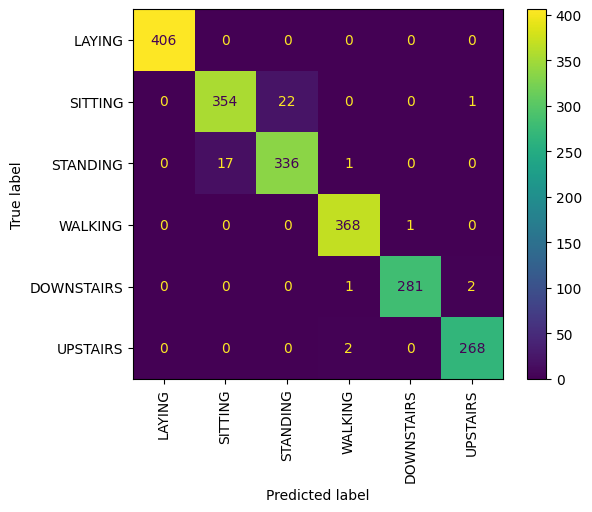

In [26]:
X_f_classif_k = SelectKBest(score_func=f_classif, k=180).fit_transform(X_t,y_t)
print('Number of best for Anova is {}'.format(X_f_classif_k.shape[1]))
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(X_f_classif_k, y, test_size=0.2, shuffle=True, random_state=42)
lin_svc_k = svm.LinearSVC().fit(x_train_k, y_train_k)
evaluate_classification(lin_svc_k, "Linear SVC(K)", x_train_k, x_test_k, y_train_k, y_test_k)

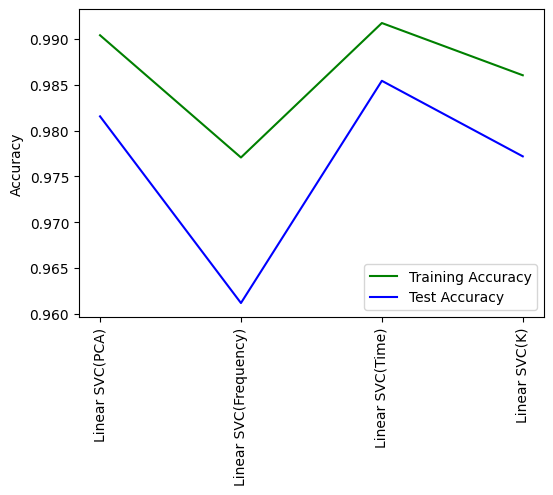

In [27]:
keys = ['Linear SVC(PCA)', 'Linear SVC(Frequency)', 'Linear SVC(Time)', 'Linear SVC(K)']
values = []
for i in keys:
    values.append(kernal_evals[i])
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(keys)), [value[0] for value in values], color='g')
ax.plot(np.arange(len(keys)), [value[1] for value in values], color='b')
ax.legend(["Training Accuracy", "Test Accuracy"])
ax.set_xticklabels(keys, rotation='vertical')
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Accuracy")
plt.show()